# Homework 1: Optimizasyon Algoritmalarının Karşılaştırılması

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035


# Metin Veri Seti Seçimi

- UCI Machine Learning Repository içerisinde bulunan [Sentiment Labelled Sentences](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences) veri seti kullanıldı.
- Veri seti içerisinde bulunan 3 farklı ortamdan veriler bulunmaktadır. Bu veriler;
  - Amazon
  - Yelp
  - IMDB
- Bu çalışma kapsamında sadece Amazon veri seti kullanıldı.
- Bu işlem literatürde sentiment analysis olarak geçmektedir. Bu işlemde metin verileri pozitif ve negatif olarak etiketlenir ve bu etiketler üzerinden sınıflandırma işlemi yapılır.
- Veri seti içerisinde 500 adet pozitif ve 500 adet negatif olmak üzere toplamda 1000 adet veri bulunmaktadır.


# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [67]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


HOMEWORK_DIR = '/Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework1/'
LOGGER_CONFIG_FILE = HOMEWORK_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.INFO)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[INFO] [2024-11-14T00:22:46.552Z] Logging is configured successfully.


# Veri Setinin Yüklenmesi

- Çalışmanın yapıldığı klasöre veri seti indirildi.
- text_data içerisine veri seti yüklendi.


In [68]:
import pandas as pd

FILE_PATH = HOMEWORK_DIR + 'text_data/amazon_cells_labelled.txt'

df = pd.read_csv(FILE_PATH, names=['sentence', 'label'], sep='\t')

# Print the first 5 rows of the dataframe
df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [69]:
# Transform labels to categorical data type
# 0: Negative, 1: Positive

temp_df = df.copy()

temp_df['label'] = temp_df['label'].astype('category')
temp_df['label'] = temp_df['label'].cat.rename_categories(['Negative', 'Positive'])

temp_df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,Negative
1,"Good case, Excellent value.",Positive
2,Great for the jawbone.,Positive
3,Tied to charger for conversations lasting more...,Negative
4,The mic is great.,Positive


In [70]:
# Make sure each class has the same number of samples
df['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

# Veri Setinin Training, Validation ve Test Olarak Ayrılması

- Her küme içerisinde pozitif ve negatif veri sayıları olabildiğince eşit olabilecek şekilde düzenlendi.


In [71]:
# split the data into training, validation and test sets
from sklearn.model_selection import train_test_split

train_df, rest_df = train_test_split(df, test_size=0.2, random_state=45)

logger.info("Size of the training set: %d", len(train_df))
train_df.head()

[INFO] [2024-11-14T00:22:46.595Z] Size of the training set: 800


,sentence,label
791,I own 2 of these cases and would order another.,1
143,very disappointed.,0
880,"The bottowm line...another worthless, cheap gi...",0
339,It is practically useless and did not add any ...,0
992,Lasted one day and then blew up.,0


In [72]:
# Make sure each class has the same number of samples
train_df['label'].value_counts()

label
1    400
0    400
Name: count, dtype: int64

In [73]:
# split the rest into validation and test sets
test_df, validation_df = train_test_split(rest_df, test_size=0.75, random_state=9)

logger.info("Size of the validation set: %d", len(validation_df))
logger.info("Values in the label column:")
display(validation_df['label'].value_counts())

validation_df.head()

[INFO] [2024-11-14T00:22:46.614Z] Size of the validation set: 150
[INFO] [2024-11-14T00:22:46.615Z] Values in the label column:


label
1    76
0    74
Name: count, dtype: int64

,sentence,label
111,This phone is slim and light and the display i...,1
612,I like design and look of Jabra behing the ear...,1
530,Keep up the good work Amazon!!,1
770,AFter the first charge kept going dead after 1...,0
4,The mic is great.,1


In [74]:
logger.info("Size of the test set: %d", len(test_df))
logger.info("Values in the label column:")
display(test_df['label'].value_counts())

test_df.head()

[INFO] [2024-11-14T00:22:46.649Z] Size of the test set: 50
[INFO] [2024-11-14T00:22:46.649Z] Values in the label column:


label
0    26
1    24
Name: count, dtype: int64

,sentence,label
243,"No additional ear gels provided, and no instru...",0
671,"A must study for anyone interested in the ""wor...",0
349,"I was sitting in my vehicle, with the cradle o...",0
747,This BlueAnt Supertooth hands-free phone speak...,1
231,What a big waste of time.,0


# Veri Setinden Özellliklerin Çıkarımı

- Veri seti üzerinde eğitim yapılabilmesi için kullanabileceğimiz özelliklerin çıkarılması gerekmektedir.
- Bunun için count vectorizer kullanıldı.
- Count vectorizer, metin verilerini sayısal verilere dönüştürmek için kullanılan bir yöntemdir.
- Count vectorizer, metin verilerini alır ve her bir kelimenin metinde kaç defa geçtiğini sayar.
- Aşağıda gördüğümüz üzere training veri setimiz (800, 1639) lik bir sparse matrise dönüşmüştür.
- Yani 800 tane sample için 1639 kelime bulunmaktadır.


In [75]:
from sklearn.feature_extraction.text import CountVectorizer

# Configure CountVectorizer to include single-letter words
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
vectorizer.fit(train_df['sentence'])

X_train = vectorizer.transform(train_df['sentence'])
y_train = train_df['label'].values


def show_first_row_word_counts(sparse_matrix, vectorizer):
    logger.info("Shape of the sparse matrix: %s", sparse_matrix.shape)

    # so we get first row and their corresponding feature name indexes
    word_indexes = sparse_matrix[0].indices
    words = vectorizer.get_feature_names_out()[word_indexes]

    # put the words and their counts in a dataframe
    word_freq = pd.DataFrame({'word': words, 'repeat_count': sparse_matrix[0].data})

    display(word_freq)


show_first_row_word_counts(X_train, vectorizer)

[INFO] [2024-11-14T00:22:46.678Z] Shape of the sparse matrix: (800, 1639)


,word,repeat_count
0,2,1
1,and,1
2,another,1
3,cases,1
4,i,1
5,of,1
6,order,1
7,own,1
8,these,1
9,would,1


- Aşağıdaki şekilde elde ettiğimiz özellikleri doğruluyoruz.
- logistic regression ile başarıma bi bakıyoruz.


In [76]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
accuracy_score = classifier.score(X_train, y_train)
logger.info("Accuracy on the training set: %.2f", accuracy_score)

[INFO] [2024-11-14T00:22:46.702Z] Accuracy on the training set: 1.00


- Train seti üzerinde fit ettiğimiz modeli validation ve test seti üzerinde kullanarak transform işlemini yapıyoruz.


In [77]:
# Fit edersek train setinin shape'i ile uyuşmaz
# vectorizer.fit(validation_df['sentence'])
X_validation = vectorizer.transform(validation_df['sentence'])
y_validation = validation_df['label'].values

show_first_row_word_counts(X_validation, vectorizer)

[INFO] [2024-11-14T00:22:46.709Z] Shape of the sparse matrix: (150, 1639)


,word,repeat_count
0,and,2
1,beautiful,1
2,display,1
3,is,2
4,light,1
5,phone,1
6,slim,1
7,the,1
8,this,1


In [78]:

# Fit edersek train setinin shape'i ile uyuşmaz
# vectorizer.fit(test_df['sentence'])
X_test = vectorizer.transform(test_df['sentence'])
y_test = test_df['label'].values

show_first_row_word_counts(X_test, vectorizer)

[INFO] [2024-11-14T00:22:46.721Z] Shape of the sparse matrix: (50, 1639)


,word,repeat_count
0,additional,1
1,and,1
2,ear,1
3,gels,1
4,instructions,1
5,no,2
6,provided,1
7,whatsoever,1


# Modelin Oluşturulması

Model olarak tüm ödev genelinde aşağıda özellikler verilen model kullanılacaktır.


In [79]:
from tensorflow.keras import layers, Sequential

# number of features
input_dimension = X_train.shape[1]

model = Sequential([
    #           Hidden Layer 10 Neurons, Input Layer 1640 Neurons
    layers.Dense(10, input_dim=input_dimension, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)               │ (None, 10)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,411 (64.11 KB)

 Trainable params: 16,411 (64.11 KB)

 Non-trainable params: 0 (0.00 B)

# Hiper Parametrelerin Optimizasyonu

- Hiper parametreleri optimize etmek için aşağıdaki gibi temel metodların yazılması gerekmektedir.
- Aşağıdaki metod hiper parametre değişimi sonrası bir tablo olarak sonuçları yazdırır.


In [80]:
# Final evaluation of the model
def get_model_results(model, optimizer_name, learning_rate, momentum, loss_function):
    results = []

    training_loss, training_accuracy = model.evaluate(X_train, y_train)
    training_accuracy = f"{training_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Train', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': training_loss, 'Accuracy': training_accuracy})

    validation_loss, validation_accuracy = model.evaluate(X_validation, y_validation)
    validation_accuracy = f"{validation_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Validation', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': validation_loss, 'Accuracy': validation_accuracy})

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    test_accuracy = f"{test_accuracy * 100:.2f}%"

    results.append({'Model': optimizer_name, 'Data': 'Test', 'Learning Rate': learning_rate, 'Momentum': momentum,
                    'Loss Function': loss_function, 'Loss': test_loss, 'Accuracy': test_accuracy})

    return pd.DataFrame(results)

# Stochastic Gradient Descent (SGD) Optimizer


## Learning Rete'in Etkisinin İncelenmesi

- Farklı learning rate ler ile modelin başarımı incelendi.
- Denenen learning rate değerleri: 0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99


In [ ]:
from tensorflow.keras.optimizers import SGD

optimizer_name = 'SGD'
moment = 'N/A'
loss_function = 'binary_crossentropy'


learning_rate_list = [0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99]

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(
        X_validation, y_validation), epochs=10, batch_size=10)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(model, optimizer_name,
                                                                                      learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5608 - loss: 0.6868 - val_accuracy: 0.5933 - val_loss: 0.6826
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6343 - loss: 0.6787 - val_accuracy: 0.6133 - val_loss: 0.6761
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7017 - loss: 0.6714 - val_accuracy: 0.6933 - val_loss: 0.6680
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7038 - loss: 0.6595 - val_accuracy: 0.7200 - val_loss: 0.6589
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7322 - loss: 0.6470 - val_accuracy: 0.7333 - val_loss: 0.6492
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7571 - loss: 0.6371 - val_accuracy: 0.7400 - val_loss: 0.6392
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7712 - loss: 0.6247 - val_accuracy: 0.7400 - val_loss: 0.6289
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7987 - loss: 0.6011 - val_accuracy: 0.7400 - val_loss: 0.6181
Epo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD,Train,0.01,N/A,binary_crossentropy,0.570350,81.00%
1,SGD,Validation,0.01,N/A,binary_crossentropy,0.597079,74.67%
2,SGD,Test,0.01,N/A,binary_crossentropy,0.623656,82.00%
3,SGD,Train,0.10,N/A,binary_crossentropy,0.098343,99.12%
4,SGD,Validation,0.10,N/A,binary_crossentropy,0.349247,83.33%
5,SGD,Test,0.10,N/A,binary_crossentropy,0.485438,80.00%
6,SGD,Train,0.40,N/A,binary_crossentropy,0.006891,100.00%
7,SGD,Validation,0.40,N/A,binary_crossentropy,0.460248,85.33%
8,SGD,Test,0.40,N/A,binary_crossentropy,0.914515,78.00%
9,SGD,Train,0.50,N/A,binary_crossentropy,0.005447,100.00%


# SGD Sonuçlar ve İnceleme

- Algoritmada 5 epoch sonunda farklı learning rate ler üzerinde yakalanan accuracy lerden en büyüğünün 80% olduğu görülmektedir.
- 5, 10 ve 20 epoch denemelerinde de sonuçların değişmediği ve 80% accuracy elde edildiği görülmektedir.
- Epoch sayının değişiminin learning rate lerin başarımı üzerine etkisi olduğu söylenebilir.
- Denenen 5, 10 ve 20 epoch için en başarılı olan learning rate ler aşağıdaki gibi;

```python
#                  Model  Data Learning Rate  Momentum  Loss Function        Loss    Accuracy
# epochs=5  --> 14  SGD   Test     0.80         N/A     binary_crossentropy  0.803046  80.0%
# epochs=10 --> 17  SGD   Test     0.90         N/A     binary_crossentropy  1.057388  80.0%
# epochs=20 --> 5   SGD   Test     0.10         N/A     binary_crossentropy  0.703760  80.0%
```


# Plotting History

Modelin çıktılarının çizdirilebilmesi için aşağıdaki gibi bir plot metodu oluşturuldu.


In [82]:
import matplotlib.pyplot as plt


def plot_history(history, optimizer_name):
    train_accuracy_percent = [acc * 100 for acc in history.history['accuracy']]
    validation_accuracy_percent = [acc * 100 for acc in history.history['val_accuracy']]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy_percent)
    plt.plot(validation_accuracy_percent)
    plt.title(optimizer_name + ' Accuracy')
    plt.ylabel('accuracy (%)')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'],)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(optimizer_name + ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.grid(True)

    plt.show()

- Parametreler optimize edildikten sonra 0.1 learning rate ve 10 epoch ile modelin başarımı ve sonuçları aşağıdaki gibi çıktı.


In [83]:
learning_rate = 0.1
model = Sequential([
    layers.Dense(10, input_dim=input_dimension, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(
    X_validation, y_validation), epochs=10, batch_size=10)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5547 - loss: 0.6828 - val_accuracy: 0.7000 - val_loss: 0.6200
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.7556 - loss: 0.5867 - val_accuracy: 0.7400 - val_loss: 0.5291
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.8313 - loss: 0.4637 - val_accuracy: 0.7600 - val_loss: 0.4903
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8620 - loss: 0.3801 - val_accuracy: 0.7667 - val_loss: 0.4208
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.9048 - loss: 0.3039 - val_accuracy: 0.7933 - val_loss: 0.4150
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.9214 - loss: 0.2560 - val_accuracy: 0.8000 - val_loss: 0.4009
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9585 - loss: 0.2006 - val_accuracy: 0.8067 - val_loss: 0.3756
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.9632 - loss: 0.1573 - val_accuracy: 0.7867 - val_lo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD,Train,0.1,N/A,binary_crossentropy,0.085053,99.75%
1,SGD,Validation,0.1,N/A,binary_crossentropy,0.356413,82.67%
2,SGD,Test,0.1,N/A,binary_crossentropy,0.576189,76.00%


- Yukarıda görüldüğü gibi **train accuracy si %99.37** ye çıktığı halde **test accuracy si %72 ile %80 arasında** değiştiği görülmektedir.
- Bu durum **overfitting** olduğunu göstermektedir.


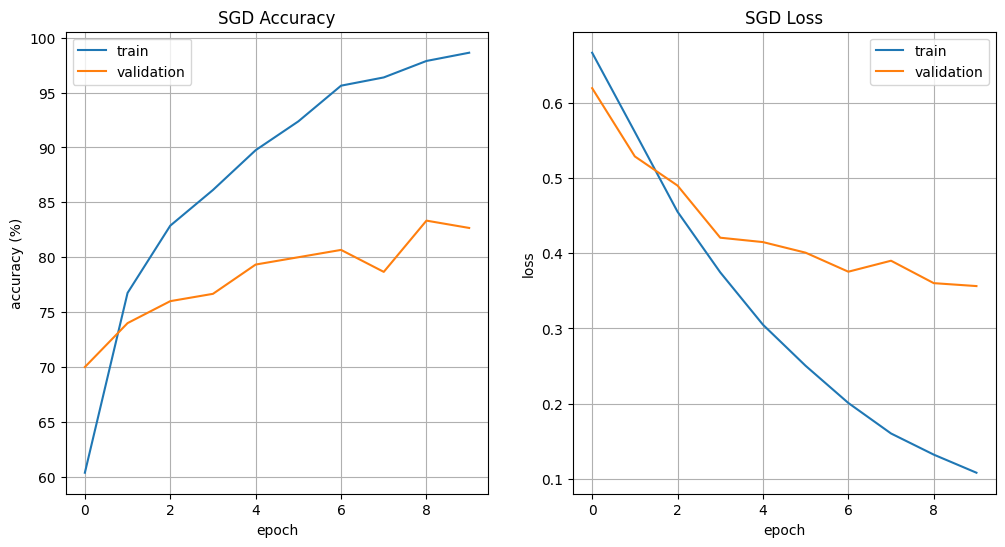

In [84]:
plot_history(history, optimizer_name)

# Prediction on Test Data

Test datası üzerindeki tahminlerin confusion matrix ile gösterilmesi için aşağıdaki gibi bir metod yazıldı.


In [85]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- Yukarıda eğittimiz modeli kullanarak test datası üzerinde tahminlerde bulunuyoruz.
- Bunu confusion matrix ile çizdiriyoruz.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion matrix, without normalization
[[17  9]
 [ 3 21]]


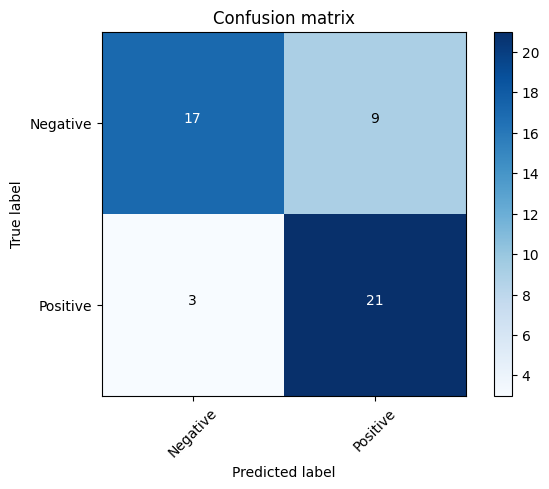

In [86]:
import numpy as np
from sklearn.metrics import confusion_matrix

predictions = model.predict(x=X_test)
y_prediction = np.round(predictions).flatten().astype(int)

cm = confusion_matrix(y_true=y_test, y_pred=y_prediction)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

Yukarıdaki matrix i yorumlamak gerekirse;

- **True Positive (TP):** 21 adet
- **True Negative (TN):** 17 adet
- **False Positive (FP):** 9 adet
- **False Negative (FN):** 3 adet
  çıkmaktadır.

* Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (21 + 17) / (21 + 17 + 9 + 3) = 38 / 50 = 0.76 = %76**


# Stochastic Gradient Descent (SGD) with Momentum

Burada SGD'nin momentum kabul eden versiyonu kullanılmıştır.


# Learning Rate ve Momentum'un Etkisinin İncelenmesi


In [87]:
optimizer_name = 'SGD with Momentum'
moment = 0.9

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=10)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4871 - loss: 0.6913 - val_accuracy: 0.7267 - val_loss: 0.6404
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6902 - loss: 0.6284 - val_accuracy: 0.7267 - val_loss: 0.5692
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.7833 - loss: 0.5197 - val_accuracy: 0.7667 - val_loss: 0.5159
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.8579 - loss: 0.4189 - val_accuracy: 0.7733 - val_loss: 0.4447
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.8804 - loss: 0.3373 - val_accuracy: 0.8000 - val_loss: 0.4249
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.9179 - loss: 0.2784 - val_accuracy: 0.8200 - val_loss: 0.3680
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.9479 - loss: 0.2249 - val_accuracy: 0.8000 - val_loss: 0.3769
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.9651 - loss: 0.1686 - val_accuracy: 0.8267 - val_lo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.01,0.9,binary_crossentropy,0.094968,99.50%
1,SGD with Momentum,Validation,0.01,0.9,binary_crossentropy,0.347320,82.67%
2,SGD with Momentum,Test,0.01,0.9,binary_crossentropy,0.570902,76.00%
3,SGD with Momentum,Train,0.10,0.9,binary_crossentropy,0.001530,100.00%
4,SGD with Momentum,Validation,0.10,0.9,binary_crossentropy,0.548263,82.67%
5,SGD with Momentum,Test,0.10,0.9,binary_crossentropy,1.190590,78.00%
6,SGD with Momentum,Train,0.40,0.9,binary_crossentropy,0.224436,92.62%
7,SGD with Momentum,Validation,0.40,0.9,binary_crossentropy,0.634678,81.33%
8,SGD with Momentum,Test,0.40,0.9,binary_crossentropy,0.872077,74.00%
9,SGD with Momentum,Train,0.50,0.9,binary_crossentropy,0.272346,85.37%


Yukarıdaki sonuçtan göründüğü üzere en başarılı olan 2 si

```python
#             Model     Data Learning Rate  Momentum  Loss Function        Loss    Accuracy
# 2  SGD with Momentum  Test  0.01            0.9  binary_crossentropy  0.647629  76.0%
# 5  SGD with Momentum  Test  0.10            0.9  binary_crossentropy  1.245013  78.0%
```

yukarıdaki learning rate 0.10 iken momentumu optimize etmeye çalışalım.


In [88]:
learning_rate_results_df = pd.DataFrame()

learning_rate = 0.1
moment_list = [0.1, 0.4, 0.5, 0.8, 0.9, 0.99]

for moment in moment_list:

    model = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=10)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5992 - loss: 0.6797 - val_accuracy: 0.7200 - val_loss: 0.6192
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.7461 - loss: 0.5900 - val_accuracy: 0.7467 - val_loss: 0.5291
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.8363 - loss: 0.4408 - val_accuracy: 0.8267 - val_loss: 0.4564
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.8736 - loss: 0.3661 - val_accuracy: 0.7667 - val_loss: 0.4230
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.9039 - loss: 0.2735 - val_accuracy: 0.8133 - val_loss: 0.3947
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.9623 - loss: 0.2168 - val_accuracy: 0.8200 - val_loss: 0.3874
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.9576 - loss: 0.1826 - val_accuracy: 0.8400 - val_loss: 0.3512
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.9763 - loss: 0.1307 - val_accuracy: 0.8200 - val_lo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.1,0.10,binary_crossentropy,0.069604,99.87%
1,SGD with Momentum,Validation,0.1,0.10,binary_crossentropy,0.363276,83.33%
2,SGD with Momentum,Test,0.1,0.10,binary_crossentropy,0.629242,76.00%
3,SGD with Momentum,Train,0.1,0.40,binary_crossentropy,0.031032,100.00%
4,SGD with Momentum,Validation,0.1,0.40,binary_crossentropy,0.391588,83.33%
5,SGD with Momentum,Test,0.1,0.40,binary_crossentropy,0.654399,78.00%
6,SGD with Momentum,Train,0.1,0.50,binary_crossentropy,0.023076,100.00%
7,SGD with Momentum,Validation,0.1,0.50,binary_crossentropy,0.424846,82.00%
8,SGD with Momentum,Test,0.1,0.50,binary_crossentropy,0.719058,78.00%
9,SGD with Momentum,Train,0.1,0.80,binary_crossentropy,0.005786,100.00%


Yukarıdakinden anlaşılacağı üzere en iyi sonucu learning rate 0.1 ve momentum 0.4 iken verdi.

```python
#             Model     Data Learning Rate  Momentum  Loss Function        Loss    Accuracy
# 5  SGD with Momentum  Test  0.1             0.40  binary_crossentropy  0.691976  80.0%
```


## Eğitilmiş Model Sonuçları

Momentum 0.4 ve learning rate 0.1 iken modeli eğitip sonuçları çıktı olarak alalım.


In [89]:
learning_rate = 0.1
moment = 0.4

model = Sequential([
    layers.Dense(10, input_dim=input_dimension, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment), loss=loss_function, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=10)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5591 - loss: 0.6779 - val_accuracy: 0.7267 - val_loss: 0.5685
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8286 - loss: 0.4969 - val_accuracy: 0.7533 - val_loss: 0.4884
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8437 - loss: 0.3953 - val_accuracy: 0.7800 - val_loss: 0.4332
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.8966 - loss: 0.2810 - val_accuracy: 0.8200 - val_loss: 0.3770
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.9663 - loss: 0.1722 - val_accuracy: 0.8133 - val_loss: 0.3879
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.9733 - loss: 0.1435 - val_accuracy: 0.8333 - val_loss: 0.3480
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.9910 - loss: 0.0984 - val_accuracy: 0.8067 - val_loss: 0.3813
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.9945 - loss: 0.0771 - val_accuracy: 0.8467 - val_lo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD with Momentum,Train,0.1,0.4,binary_crossentropy,0.031760,100.00%
1,SGD with Momentum,Validation,0.1,0.4,binary_crossentropy,0.364187,84.67%
2,SGD with Momentum,Test,0.1,0.4,binary_crossentropy,0.661992,80.00%


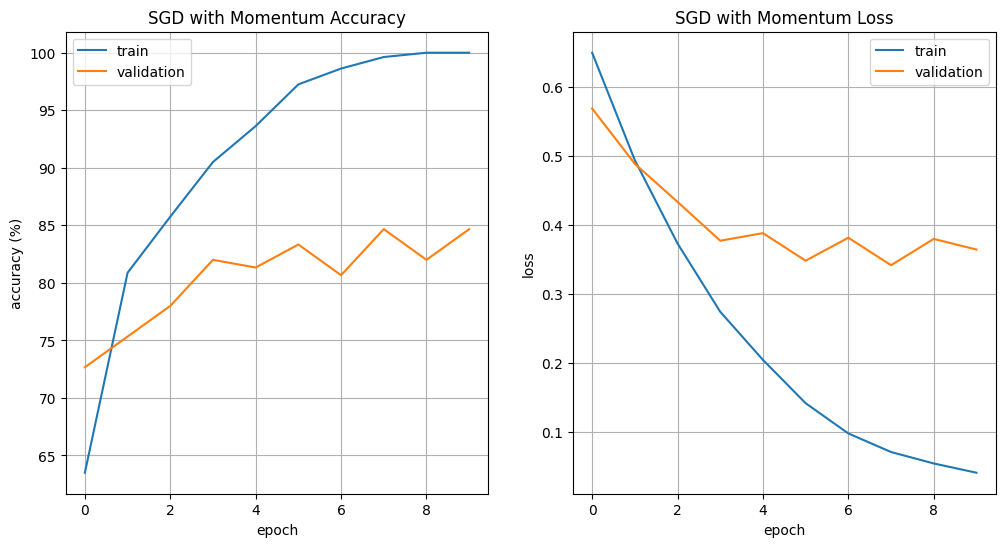

In [90]:
plot_history(history, optimizer_name)

## Test Datası Üzerinde Tahmin Yapılması


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Confusion matrix, without normalization
[[18  8]
 [ 2 22]]


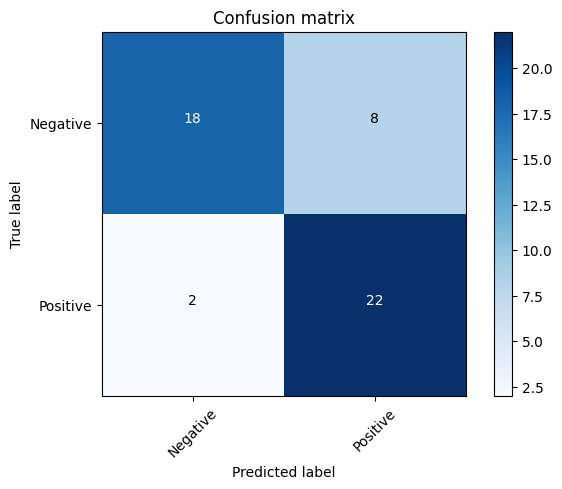

In [91]:
predictions = model.predict(x=X_test)
y_prediction = np.round(predictions).flatten().astype(int)

cm = confusion_matrix(y_true=y_test, y_pred=y_prediction)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

Yukarıdaki matrix i yorumlamak gerekirse;

- **True Positive (TP):** 22 adet
- **True Negative (TN):** 18 adet
- **False Positive (FP):** 8 adet
- **False Negative (FN):** 2 adet
  çıkmaktadır.

* Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (22 + 18) / (22 + 18 + 8 + 2) = 40 / 50 = 0.80 = %80** çıkmaktadır.


# Adam Optimizer

Adamp optimizer için parametreleri optimize edelim.


# Learning Rate Etkisinin İncelenmesi

- Farklı learning rate ler ile modelin başarımı aşağıdaki şekilde incelenmiştir.


In [92]:
from tensorflow.keras.optimizers import Adam

optimizer_name = 'Adam'
moment = 'N/A'

learning_rate_results_df = pd.DataFrame()

for learning_rate in learning_rate_list:

    model = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=10)

    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6335 - loss: 0.6395 - val_accuracy: 0.8133 - val_loss: 0.4350
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9444 - loss: 0.2132 - val_accuracy: 0.8333 - val_loss: 0.3815
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9891 - loss: 0.0622 - val_accuracy: 0.8467 - val_loss: 0.4329
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9987 - loss: 0.0220 - val_accuracy: 0.8133 - val_loss: 0.4407
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9996 - loss: 0.0073 - val_accuracy: 0.8200 - val_loss: 0.4582
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.9973 - loss: 0.0056 - val_accuracy: 0.8133 - val_loss: 0.4808
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.8200 - val_loss: 0.4892
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.8333 - val_loss: 

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,Adam,Train,0.01,N/A,binary_crossentropy,0.001872,99.87%
1,Adam,Validation,0.01,N/A,binary_crossentropy,0.519178,82.67%
2,Adam,Test,0.01,N/A,binary_crossentropy,0.997569,82.00%
3,Adam,Train,0.10,N/A,binary_crossentropy,0.033794,97.75%
4,Adam,Validation,0.10,N/A,binary_crossentropy,0.861973,79.33%
5,Adam,Test,0.10,N/A,binary_crossentropy,1.614157,80.00%
6,Adam,Train,0.40,N/A,binary_crossentropy,0.299606,85.50%
7,Adam,Validation,0.40,N/A,binary_crossentropy,0.654632,70.00%
8,Adam,Test,0.40,N/A,binary_crossentropy,0.477540,74.00%
9,Adam,Train,0.50,N/A,binary_crossentropy,0.598816,62.25%


- Yukarıdaki sonuçlardan görüldüğü üzere en başarılı learning rate 0.01 olarak gerçekleşmiştir.
- Accuracy 82% olarak gerçekleşmiştir.
- Algoritmaları karşılaştıracğamız için 0.1 learning rate ile elde edilen sonuçları ele alacağız.

```python
#    Model  Data Learning Rate  Momentum    Loss Function        Loss    Accuracy
# 2  Adam  Test  0.01              N/A    binary_crossentropy  0.946054  78.00%
# 5  Adam  Test  0.10              N/A    binary_crossentropy  2.202564  76.00%
```


## Eğitilmiş Model Sonuçları

Learning rate 0.1 iken modeli eğitip sonuçları çıktı olarak alalım.


In [93]:
optimizer_name = 'Adam'
learning_rate = 0.1
moment = 'N/A'

model = Sequential([
    layers.Dense(10, input_dim=input_dimension, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=10)

learning_rate_results_df = get_model_results(model, optimizer_name, learning_rate, moment, loss_function)

learning_rate_results_df

Epoch 1/10


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4789 - loss: 0.7061 - val_accuracy: 0.6800 - val_loss: 0.5883
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7809 - loss: 0.5185 - val_accuracy: 0.7800 - val_loss: 0.4646
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.9117 - loss: 0.2081 - val_accuracy: 0.8267 - val_loss: 0.4752
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.9257 - loss: 0.1589 - val_accuracy: 0.8000 - val_loss: 0.5876
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.9463 - loss: 0.1066 - val_accuracy: 0.8267 - val_loss: 0.6812
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9530 - loss: 0.0926 - val_accuracy: 0.8267 - val_loss: 0.6387
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.9443 - loss: 0.0916 - val_accuracy: 0.8267 - val_loss: 0.5574
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9566 - loss: 0.0809 - val_accuracy: 0.8000 - val_lo

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,Adam,Train,0.1,N/A,binary_crossentropy,0.056729,97.00%
1,Adam,Validation,0.1,N/A,binary_crossentropy,0.622099,81.33%
2,Adam,Test,0.1,N/A,binary_crossentropy,1.007679,76.00%


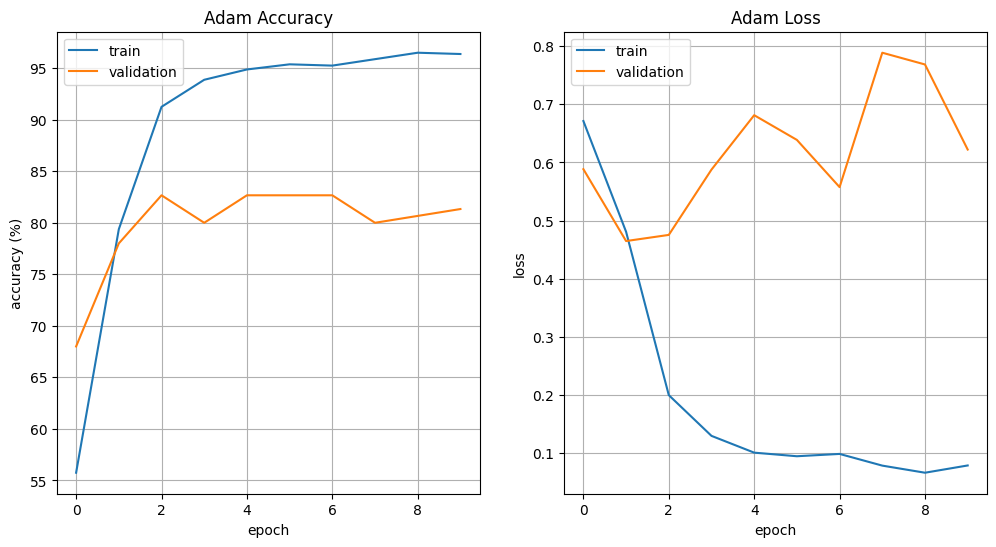

In [94]:
plot_history(history, optimizer_name)

# Test Datası Üzerinde Tahmin Yapılması


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion matrix, without normalization
[[17  9]
 [ 3 21]]


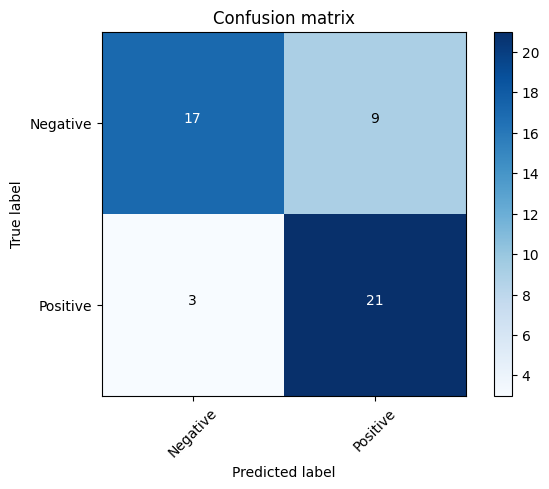

In [95]:
predictions = model.predict(x=X_test)
y_prediction = np.round(predictions).flatten().astype(int)

cm = confusion_matrix(y_true=y_test, y_pred=y_prediction)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

Yukarıdaki matrix i yorumlamak gerekirse;

- **True Positive (TP):** 21 adet
- **True Negative (TN):** 17 adet
- **False Positive (FP):** 9 adet
- **False Negative (FN):** 3 adet
  çıkmaktadır.

* Buradan accuracy hesaplarsak;

**Accuracy = (TP + TN) / (TP + TN + FP + FN) = (21 + 17) / (21 + 17 + 9 + 3) = 38 / 50 = 0.76 = %76**


# 5 Farklı Başlangıç Noktası için Algoritmaların Karşılaştırılması


- Initial weightlerin etkisini görmek için 5 farklı başlangıç noktası ile modeli eğitip sonuçları çıktı olarak değerlendireceğiz.


[INFO] [2024-11-14T00:25:16.320Z] Epoch: 1


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5004 - loss: 4.2729 - val_accuracy: 0.6133 - val_loss: 1.2466
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4992 - loss: 3.6765 - val_accuracy: 0.6667 - val_loss: 0.8295
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6836 - loss: 0.7909 - val_accuracy: 0.8133 - val_loss: 0.4221
[INFO] [2024-11-14T00:25:18.650Z] Epoch: 2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5497 - loss: 1.9831 - val_accuracy: 0.7000 - val_loss: 0.8317
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6120 - loss: 1.7174 - val_accuracy: 0.5933 - val_loss: 1.2523
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.1154 - val_accuracy: 0.8267 - val_loss: 0.6637
[INFO] [2024-11-14T00:25:19.466Z] Epoch: 3
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7037 - loss: 0.9895 - val_accuracy: 0.7067 - val_loss: 0.7632
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6997 - loss: 1.1381 - val_accuracy: 0.7267 - val_loss: 0

,SGD,SGD with Momentum,Adam
0,8215.207919,8215.207919,8215.207919
1,8156.033203,8145.866211,7870.620117
2,8124.156250,8104.963379,7706.524902
3,8108.569824,8081.355469,7584.726074
4,8097.900879,8064.400879,7631.543945
5,8087.370605,8054.291504,7595.595703
6,8076.151367,8049.040527,7608.296387
7,8069.587891,8045.751953,7624.843262
8,8066.863770,8044.021484,7636.320312
9,8061.977051,8039.692871,7647.197266


 3/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.2080  

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.9514 - loss: 0.1684
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.4666
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7404 - loss: 0.7210  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.9786 - loss: 0.0733
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8377 - loss: 0.5066
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8279 - loss: 0.4365
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 1.0000 - loss: 2.0884e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8389 - loss: 0.6757
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7567 - loss: 1.9698  
[INFO] [2024-11-14T00:25:26.937Z] Epoch: 1


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5064 - loss: 4.0880 - val_accuracy: 0.5067 - val_loss: 2.8601
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4734 - loss: 3.4524 - val_accuracy: 0.6467 - val_loss: 0.9555
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6430 - loss: 1.3086 - val_accuracy: 0.8200 - val_loss: 0.4660
[INFO] [2024-11-14T00:25:29.079Z] Epoch: 2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5241 - loss: 2.4481 - val_accuracy: 0.6800 - val_loss: 0.7527
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6251 - loss: 1.3059 - val_accuracy: 0.6400 - val_loss: 1.5884
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9752 - loss: 0.1047 - val_accuracy: 0.8133 - val_loss: 0.5961
[INFO] [2024-11-14T00:25:29.834Z] Epoch: 3
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5492 - loss: 1.6798 - val_accuracy: 0.6267 - val_loss: 0.7812
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7139 - loss: 1.0265 - val_accuracy: 0.7667 - val_loss: 0

,SGD,SGD with Momentum,Adam
0,8130.416217,8130.416217,8130.416217
1,8077.131836,8050.644043,7812.981445
2,8035.907715,8019.626465,7759.166504
3,8009.850098,7989.668457,7786.096191
4,7995.535156,7977.016113,7806.489746
5,7983.476562,7966.870605,7797.292480
6,7978.210938,7959.449707,7822.299805
7,7972.802246,7955.588867,7763.605469
8,7969.291504,7952.305664,7749.923340
9,7964.712402,7950.779297,7768.688477


 2/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8359 - loss: 0.3683

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.8608 - loss: 0.3290
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7477 - loss: 0.6136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8383 - loss: 0.4333
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9839 - loss: 0.0894
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8089 - loss: 0.5646  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7804 - loss: 0.8274 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 1.0000 - loss: 2.2168e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8731 - loss: 0.7151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7671 - loss: 1.5014
[INFO] [2024-11-14T00:25:37.745Z] Epoch: 1


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5284 - loss: 3.7850 - val_accuracy: 0.4933 - val_loss: 5.6327
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5334 - loss: 3.1106 - val_accuracy: 0.6400 - val_loss: 0.9253
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6132 - loss: 1.9206 - val_accuracy: 0.8067 - val_loss: 0.4483
[INFO] [2024-11-14T00:25:40.030Z] Epoch: 2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5555 - loss: 2.6688 - val_accuracy: 0.6600 - val_loss: 0.7179
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6142 - loss: 1.4733 - val_accuracy: 0.6933 - val_loss: 1.1719
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1456 - val_accuracy: 0.8267 - val_loss: 0.5397
[INFO] [2024-11-14T00:25:40.795Z] Epoch: 3
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 1.4040 - val_accuracy: 0.6867 - val_loss: 0.7220
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6917 - loss: 1.0440 - val_accuracy: 0.6933 - val_loss: 0

,SGD,SGD with Momentum,Adam
0,8213.209286,8213.209286,8213.209286
1,8162.813477,8141.164551,7376.049316
2,8125.733887,8090.748535,7162.899902
3,8103.416504,8065.678223,7083.573242
4,8083.451660,8049.784668,7116.308594
5,8071.753418,8039.221191,7106.558594
6,8063.654297,8036.285645,7132.758789
7,8058.440918,8029.693848,7146.640137
8,8054.393555,8028.379395,7160.502930
9,8051.460938,8027.883301,7171.024414


 2/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - loss: 0.3585  

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8318 - loss: 0.3621
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7323 - loss: 0.7869
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6617 - loss: 1.3456
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.9964 - loss: 0.0519
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.7258
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7671 - loss: 0.7167
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 1.0000 - loss: 3.3257e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8656 - loss: 0.5191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7908 - loss: 1.6020
[INFO] [2024-11-14T00:25:48.548Z] Epoch: 1


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5098 - loss: 3.8898 - val_accuracy: 0.5067 - val_loss: 2.7949
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5107 - loss: 4.0158 - val_accuracy: 0.5067 - val_loss: 7.9270
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6662 - loss: 1.0091 - val_accuracy: 0.8067 - val_loss: 0.4734
[INFO] [2024-11-14T00:25:50.797Z] Epoch: 2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5532 - loss: 2.7013 - val_accuracy: 0.7200 - val_loss: 0.6411
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5999 - loss: 2.1800 - val_accuracy: 0.5600 - val_loss: 3.6905
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1222 - val_accuracy: 0.8467 - val_loss: 0.5768
[INFO] [2024-11-14T00:25:51.790Z] Epoch: 3
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6431 - loss: 1.3909 - val_accuracy: 0.7000 - val_loss: 0.6925
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6731 - loss: 1.6102 - val_accuracy: 0.7333 - val_loss: 0

,SGD,SGD with Momentum,Adam
0,8204.452113,8204.452113,8204.452113
1,8155.125000,8127.046875,7616.716797
2,8121.302734,8073.963867,7688.501953
3,8100.590820,8048.651855,7704.933105
4,8085.821289,8033.728516,7718.198730
5,8066.711426,8020.179199,7700.616699
6,8058.550293,8013.491699,7718.848145
7,8049.421875,8006.687500,7729.829102
8,8046.352051,8003.362793,7740.333496
9,8040.928711,8002.696289,7749.937988


 3/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9045 - loss: 0.2333  

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.9269 - loss: 0.2037
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7977 - loss: 0.4792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.4497  
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.9308 - loss: 0.1597
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8080 - loss: 0.6168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8146 - loss: 0.4735
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 1.0000 - loss: 2.0508e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.5276
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8042 - loss: 1.4204
[INFO] [2024-11-14T00:25:59.676Z] Epoch: 1


/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5308 - loss: 3.4673 - val_accuracy: 0.4933 - val_loss: 2.2520
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5407 - loss: 2.9257 - val_accuracy: 0.6333 - val_loss: 1.1934
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6422 - loss: 1.4140 - val_accuracy: 0.8267 - val_loss: 0.4339
[INFO] [2024-11-14T00:26:01.849Z] Epoch: 2
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5653 - loss: 2.3613 - val_accuracy: 0.6667 - val_loss: 0.8256
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6816 - loss: 1.1908 - val_accuracy: 0.7200 - val_loss: 0.7596
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1542 - val_accuracy: 0.7933 - val_loss: 0.6895
[INFO] [2024-11-14T00:26:02.626Z] Epoch: 3
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6115 - loss: 1.5979 - val_accuracy: 0.6667 - val_loss: 1.5573
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.9837 - val_accuracy: 0.7333 - val_loss: 1

,SGD,SGD with Momentum,Adam
0,8202.211339,8202.211339,8202.211339
1,8153.415039,8127.228516,7727.978516
2,8119.630371,8089.647949,7907.486328
3,8091.304688,8063.669922,7977.622559
4,8079.282227,8048.702148,7992.654297
5,8067.493164,8040.829102,8018.434570
6,8061.816406,8031.500977,8045.064941
7,8055.270996,8027.729492,8067.049316
8,8051.474609,8024.316895,8084.062988
9,8046.959961,8022.447266,8100.051758


 2/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.1935  

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.9503 - loss: 0.1503
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7773 - loss: 0.5380
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6825 - loss: 0.7421
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.9356 - loss: 0.1597
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.7146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7358 - loss: 1.0763
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 1.0000 - loss: 2.7950e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8202 - loss: 0.6543
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7538 - loss: 1.8704  


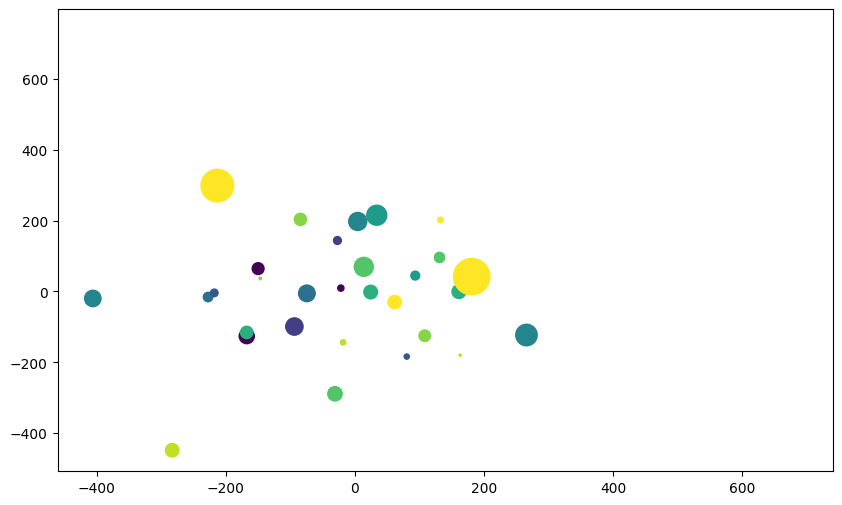

,Model,Data,Learning Rate,Momentum,Loss Function,Loss,Accuracy
0,SGD,Train,0.1,N/A,binary_crossentropy,0.175752,94.75%
1,SGD,Validation,0.1,N/A,binary_crossentropy,0.503793,80.67%
2,SGD,Test,0.1,N/A,binary_crossentropy,0.771029,72.00%
3,SGD with Momentum,Train,0.1,0.4,binary_crossentropy,0.076540,97.75%
4,SGD with Momentum,Validation,0.1,0.4,binary_crossentropy,0.570217,83.33%
5,SGD with Momentum,Test,0.1,0.4,binary_crossentropy,0.464656,82.00%
6,Adam,Train,0.1,N/A,binary_crossentropy,0.000209,100.00%
7,Adam,Validation,0.1,N/A,binary_crossentropy,0.783099,82.67%
8,Adam,Test,0.1,N/A,binary_crossentropy,1.890814,76.00%
9,SGD,Train,0.1,N/A,binary_crossentropy,0.343310,86.25%


In [98]:
from sklearn.manifold import TSNE

learning_rate_results_df = pd.DataFrame()

learning_rate = 0.1
iteration_count = 5

plt.figure(figsize=(10, 6))

for i in range(iteration_count):

    model_sgd = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model_sgdw = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model_adam = Sequential([
        layers.Dense(10, input_dim=input_dimension, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Specify the initial weights for the first Dense layer
    initial_weights = np.random.rand(input_dimension, 10)
    initial_biases = np.random.rand(10)

    # Set the initial weights for the first Dense layer
    model_sgd.layers[0].set_weights([initial_weights, initial_biases])
    model_sgdw.layers[0].set_weights([initial_weights, initial_biases])
    model_adam.layers[0].set_weights([initial_weights, initial_biases])

    model_sgd.compile(optimizer=SGD(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])
    moment = 0.4
    model_sgdw.compile(optimizer=SGD(learning_rate=learning_rate, momentum=moment),
                       loss=loss_function, metrics=['accuracy'])
    model_adam.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])

    ############################################################################################################

    sgd_sums = []
    sgdw_sums = []
    adam_sums = []
    sgd_sums.append(initial_weights.sum())
    sgdw_sums.append(initial_weights.sum())
    adam_sums.append(initial_weights.sum())

    n_of_epochs = 10
    for i in range(n_of_epochs):
        logger.info("Epoch: %d", i + 1)

        # Train the model
        model_sgd.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=1, batch_size=10)
        model_sgdw.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=1, batch_size=10)
        model_adam.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=1, batch_size=10)

        sgd_sums.append(model_sgd.layers[0].get_weights()[0].sum())
        sgdw_sums.append(model_sgdw.layers[0].get_weights()[0].sum())
        adam_sums.append(model_adam.layers[0].get_weights()[0].sum())

    ############################################################################################################

    # create data frame from sums
    sums_of_optimezers_df = pd.DataFrame({'SGD': sgd_sums, 'SGD with Momentum': sgdw_sums, 'Adam': adam_sums})
    display(sums_of_optimezers_df)

    tsne = TSNE(n_components=3, perplexity=10, random_state=42)
    tsne_results = tsne.fit_transform(sums_of_optimezers_df)

    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=['SGD', 'SGD with Momentum', 'Adam'])
    tsne_df['Epoch'] = np.array([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

    # Plot the t-SNE results
    plt.scatter(tsne_df['SGD'], tsne_df['SGD with Momentum'], tsne_df['Adam'], c=tsne_df['Epoch'], cmap='viridis')

    ############################################################################################################

    optimizer_name = 'SGD'
    moment = 'N/A'
    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model_sgd, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

    optimizer_name = 'SGD with Momentum'
    moment = 0.4
    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model_sgdw, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)

    optimizer_name = 'Adam'
    moment = 'N/A'
    learning_rate_results_df = pd.concat([learning_rate_results_df, get_model_results(
        model_adam, optimizer_name, learning_rate, moment, loss_function)], ignore_index=True)


plt.show()
learning_rate_results_df

# Sonuçlar

- Ağırlıkların update i konusunda en yüksek update hızına göre sıralama;
  - Adam > SGD with Momentum > SGD şeklinde olmuştur.
- Initial weight lerin SGD'nin çalışmasında önemli olduğu görülmüştür.
  - SGD with Momentum ve Adam optimizerlerde initial weight lerin etkisi daha azdır.
  - Özellikle bazı noktalarda SGD çuvallarken diğer optimizerlerin daha iyi sonuçlar verdiği görülmüştür.


# Referanslar

- [Text Classification With Python and Keras](https://www.kaggle.com/code/sanikamal/text-classification-with-python-and-keras)
- [Youtube - Layers in a Neural Network explained](https://www.youtube.com/watch?v=FK77zZxaBoI)
- [Youtube - t-SNE | Machine Learning from Scratch](https://www.youtube.com/watch?v=FGhAz-EAClY)
